In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
import matplotlib as mpl

import numpy as np
import numpy.linalg as la

import time
import glob,os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from PIL import Image
from imageio import imread

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
prop = mfm.FontProperties(fname=font_path)


# Loading data

Print labels in the dataset

## Get features from trained CNN 

ConvNet has 2 Convolutional layers and 2 Fully Connected layers. The model is trained in the IPython Notebook conv.ipynb and the parameters are saved.

In [2]:
def l_re_int(L, j, P, trancated_P):
    if j == -1:
        try:
            group = L[P['leaves'][:int(trancated_P['ivl'][0][1:-1])]]
            return group
        except: 
            return L[P['leaves'][0]]
    
    try:
        a = sum([int(trancated_P['ivl'][i][1:-1]) for i in range(0,j+1)])
        b = sum([int(trancated_P['ivl'][i][1:-1]) for i in range(0,j+2)])
        return L[P['leaves'][a:b]]
    except:
        modifyP = trancated_P['ivl'].copy()
        for i in range(len(modifyP)):
            v = modifyP[i]
            
            if v[0] != '(':
                modifyP[i] = '(1)'
#         print('modify:', trancated_P['ivl'],'to', modifyP)
        a = sum([int(modifyP[i][1:-1]) for i in range(0,j+1)])
        b = sum([int(modifyP[i][1:-1]) for i in range(0,j+2)])
                
        return L[P['leaves'][a:b]]


In [3]:
import scipy
import seaborn
def plot_circular_tree(P, L, pos=None, r1 = 60):
    
    icoord = scipy.array(P['icoord'])
    dcoord = scipy.array(P['dcoord'])
    color_list = scipy.array(P['color_list'])
    
    xmin, xmax = icoord.min(), icoord.max()
    ymin, ymax = dcoord.min(), dcoord.max()
    if pos:
        icoord = icoord[pos]
        dcoord = dcoord[pos]
        color_list = color_list[pos]
        
    maxxs = np.amax(icoord)
    maxys = np.amax(dcoord)
    side = max(int(len(color_list)/15),10)
    fig = plt.figure(figsize = (side, side))
    ax = fig.add_subplot(111, projection='polar')
    
    for xs, ys, color in zip(icoord, dcoord, color_list):
        if color != 'b':
            ax.plot(2*np.pi*xs/maxxs,-2*ys+r1, color)
        
    minthetas = np.amin(icoord)/maxxs
    xx = 2*np.pi*np.arange(minthetas, 1+minthetas,(1+minthetas)/len(dn2['leaves']))   
    yy = r1*np.ones(len(dn2['leaves']))
    
    ax.scatter(xx, yy, alpha=0.75, c = cmap[colorsl])
    for i in range(len(xx)):
        if i%2 == 0:
            indent = 4
        else: 
            indent = 2
        ax.text(xx[i], yy[i]+indent, L[dn2['leaves']][i], 
                horizontalalignment='center',verticalalignment='center',
                fontproperties=prop, color = cmap[colorsl][i], size = 14*np.sqrt(side/10), alpha = 0.8)
    plt.axis("off")
        
   

In [6]:
tot_vect_conv = np.load("./results/tot_vect_conv.npy")

## load K-mean results

In [7]:
U = np.load("./results/k_mean_15classes.npy",allow_pickle=True)

In [8]:
cl = U.item().get("cl")
c =  U.item().get("c")
k =  U.item().get("k")

In [9]:
L = np.load("./results/L.npy",allow_pickle=True)

## Clustering the feature maps using dendrogram

In [10]:
cl

tensor([ 0,  1,  2,  ..., 14,  7,  2])

In [11]:
from scipy.cluster import hierarchy
import plotly.figure_factory as ff
import seaborn
import matplotlib as mpl
from matplotlib.pyplot import cm
cmap = cm.tab20(np.linspace(0, 1, 20))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:20]) for rgb in cmap])


np.unique(cl)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

## Get linkage list for each class of k-mean

In [12]:
all_Z = []
Ls = []
for i in np.unique(cl):
    class1 = np.where(cl == i)[0]

    L = np.array(L)
    L1 = np.array(L)[class1]
    Ls.append(L1)
    X = np.array(tot_vect_conv)[class1]

    Z = hierarchy.linkage(X, 'ward', metric='euclidean')  
    all_Z.append(Z)

In [25]:
j = 0
subgroup_hier = {}
for Z in all_Z:
    
    dn2 = hierarchy.dendrogram(Z, no_plot= True,
                              color_threshold= 8)
    color_list = dn2["color_list"]
    P = len(np.unique(color_list))-1
    print(P)
    
    trancated_dn = hierarchy.dendrogram(Z, no_plot= True, truncate_mode= 'lastp', p = P)
    plt.show()
    L = Ls[j]
    
    print("class:", j)
    fname = l_re_int(L, -1, dn2, trancated_dn)
    groups_names = [str(fname)]
    print("group 1:", groups_names[0])
    
    colorsl = len(fname)*[0]
    for i in range(P-1):
        names = l_re_int(L, i, dn2, trancated_dn)

        groups_names.append(str(names))

        colorsl += len(names)*[i+1]
        print("group %d:"%(i+2), names)
    subgroup_hier[j] = groups_names
   
    
#     plot_circular_tree(dn2, L)
#     plt.text(0,0,"Group: %d"%j,horizontalalignment='center',verticalalignment='center', fontsize = 20)
#     plt.tight_layout()
#     plt.savefig("./image/dengrograms/group_%d.pdf"%j)
#     plt.show()
    j +=1
    



10
class: 0
group 1: ['匯' '匜' '區' '匽' '匴' '匱']
group 2: ['喦' '呂' '厔' '壓' '凰' '凤' '夙' '厎' '匾' '叵' '厨']
group 3: ['圔' '圖' '圌' '圚' '圓' '圜' '園']
group 4: ['咼' '囿' '圄' '圁' '圊' '周' '圈' '司' '向' '同' '問' '囧' '冏']
group 5: ['卩' '刂' '凸' '口' '凵' '囗' '四' '凹' '回']
group 6: ['囪' '卤' '囱' '囟' '呴' '匈' '匐']
group 7: ['囮' '囫' '图' '圇' '囹' '囵']
group 8: ['圃' '團' '固' '囤' '囝' '国' '圉' '围' '圛' '圍' '圂' '國']
group 9: ['両' '兩' '凾' '函' '凼']
group 10: ['匟' '圆' '园' '囥' '內' '冈' '凶' '囷' '困' '因' '囚' '团' '囡']
9
class: 1
group 1: ['嗆' '凔' '噲' '噙' '啥' '唅' '咍' '哈' '喰' '啽']
group 2: ['嗿' '囋' '噴' '嘳' '嘖' '嗩' '嗊']
group 3: ['喳' '喀' '唔' '嗒' '咯' '喒' '噆' '嗋']
group 4: ['嗃' '嚆' '嚐' '噶' '噹' '凊' '唶' '喏' '喑' '嗜' '喈' '唁' '咭' '嘻' '喧' '噎' '唷' '啃'
 '噫' '哨' '嘀']
group 5: ['哠' '嗐' '咶' '呫' '哐' '喭' '嚾' '嘱' '嚕' '噜' '嘈' '噌' '嘒' '噂' '嚄']
group 6: ['嘎' '嗄' '嗔' '嗅' '唣' '喤' '啅' '啍' '哼' '嘄' '嗚' '嗢' '唚' '嚎' '喨']
group 7: ['咺' '咡' '咀' '唭' '唄' '啿' '咁']
group 8: ['喎' '凋' '啁' '嘔' '嘓' '哃']
group 9: ['喟' '唱' '啗' '咱' '呜' '喁' '喂' '哏' '唈' '嗝' '喝' '噣' '堕' '墮'

In [27]:
# np.save("./commoncharacter>500_trained_result_image_24/data_for_bokeh/subgroup_hier.npy" ,subgroup_hier)

In [654]:
print(len(color_list)/15)

16.2


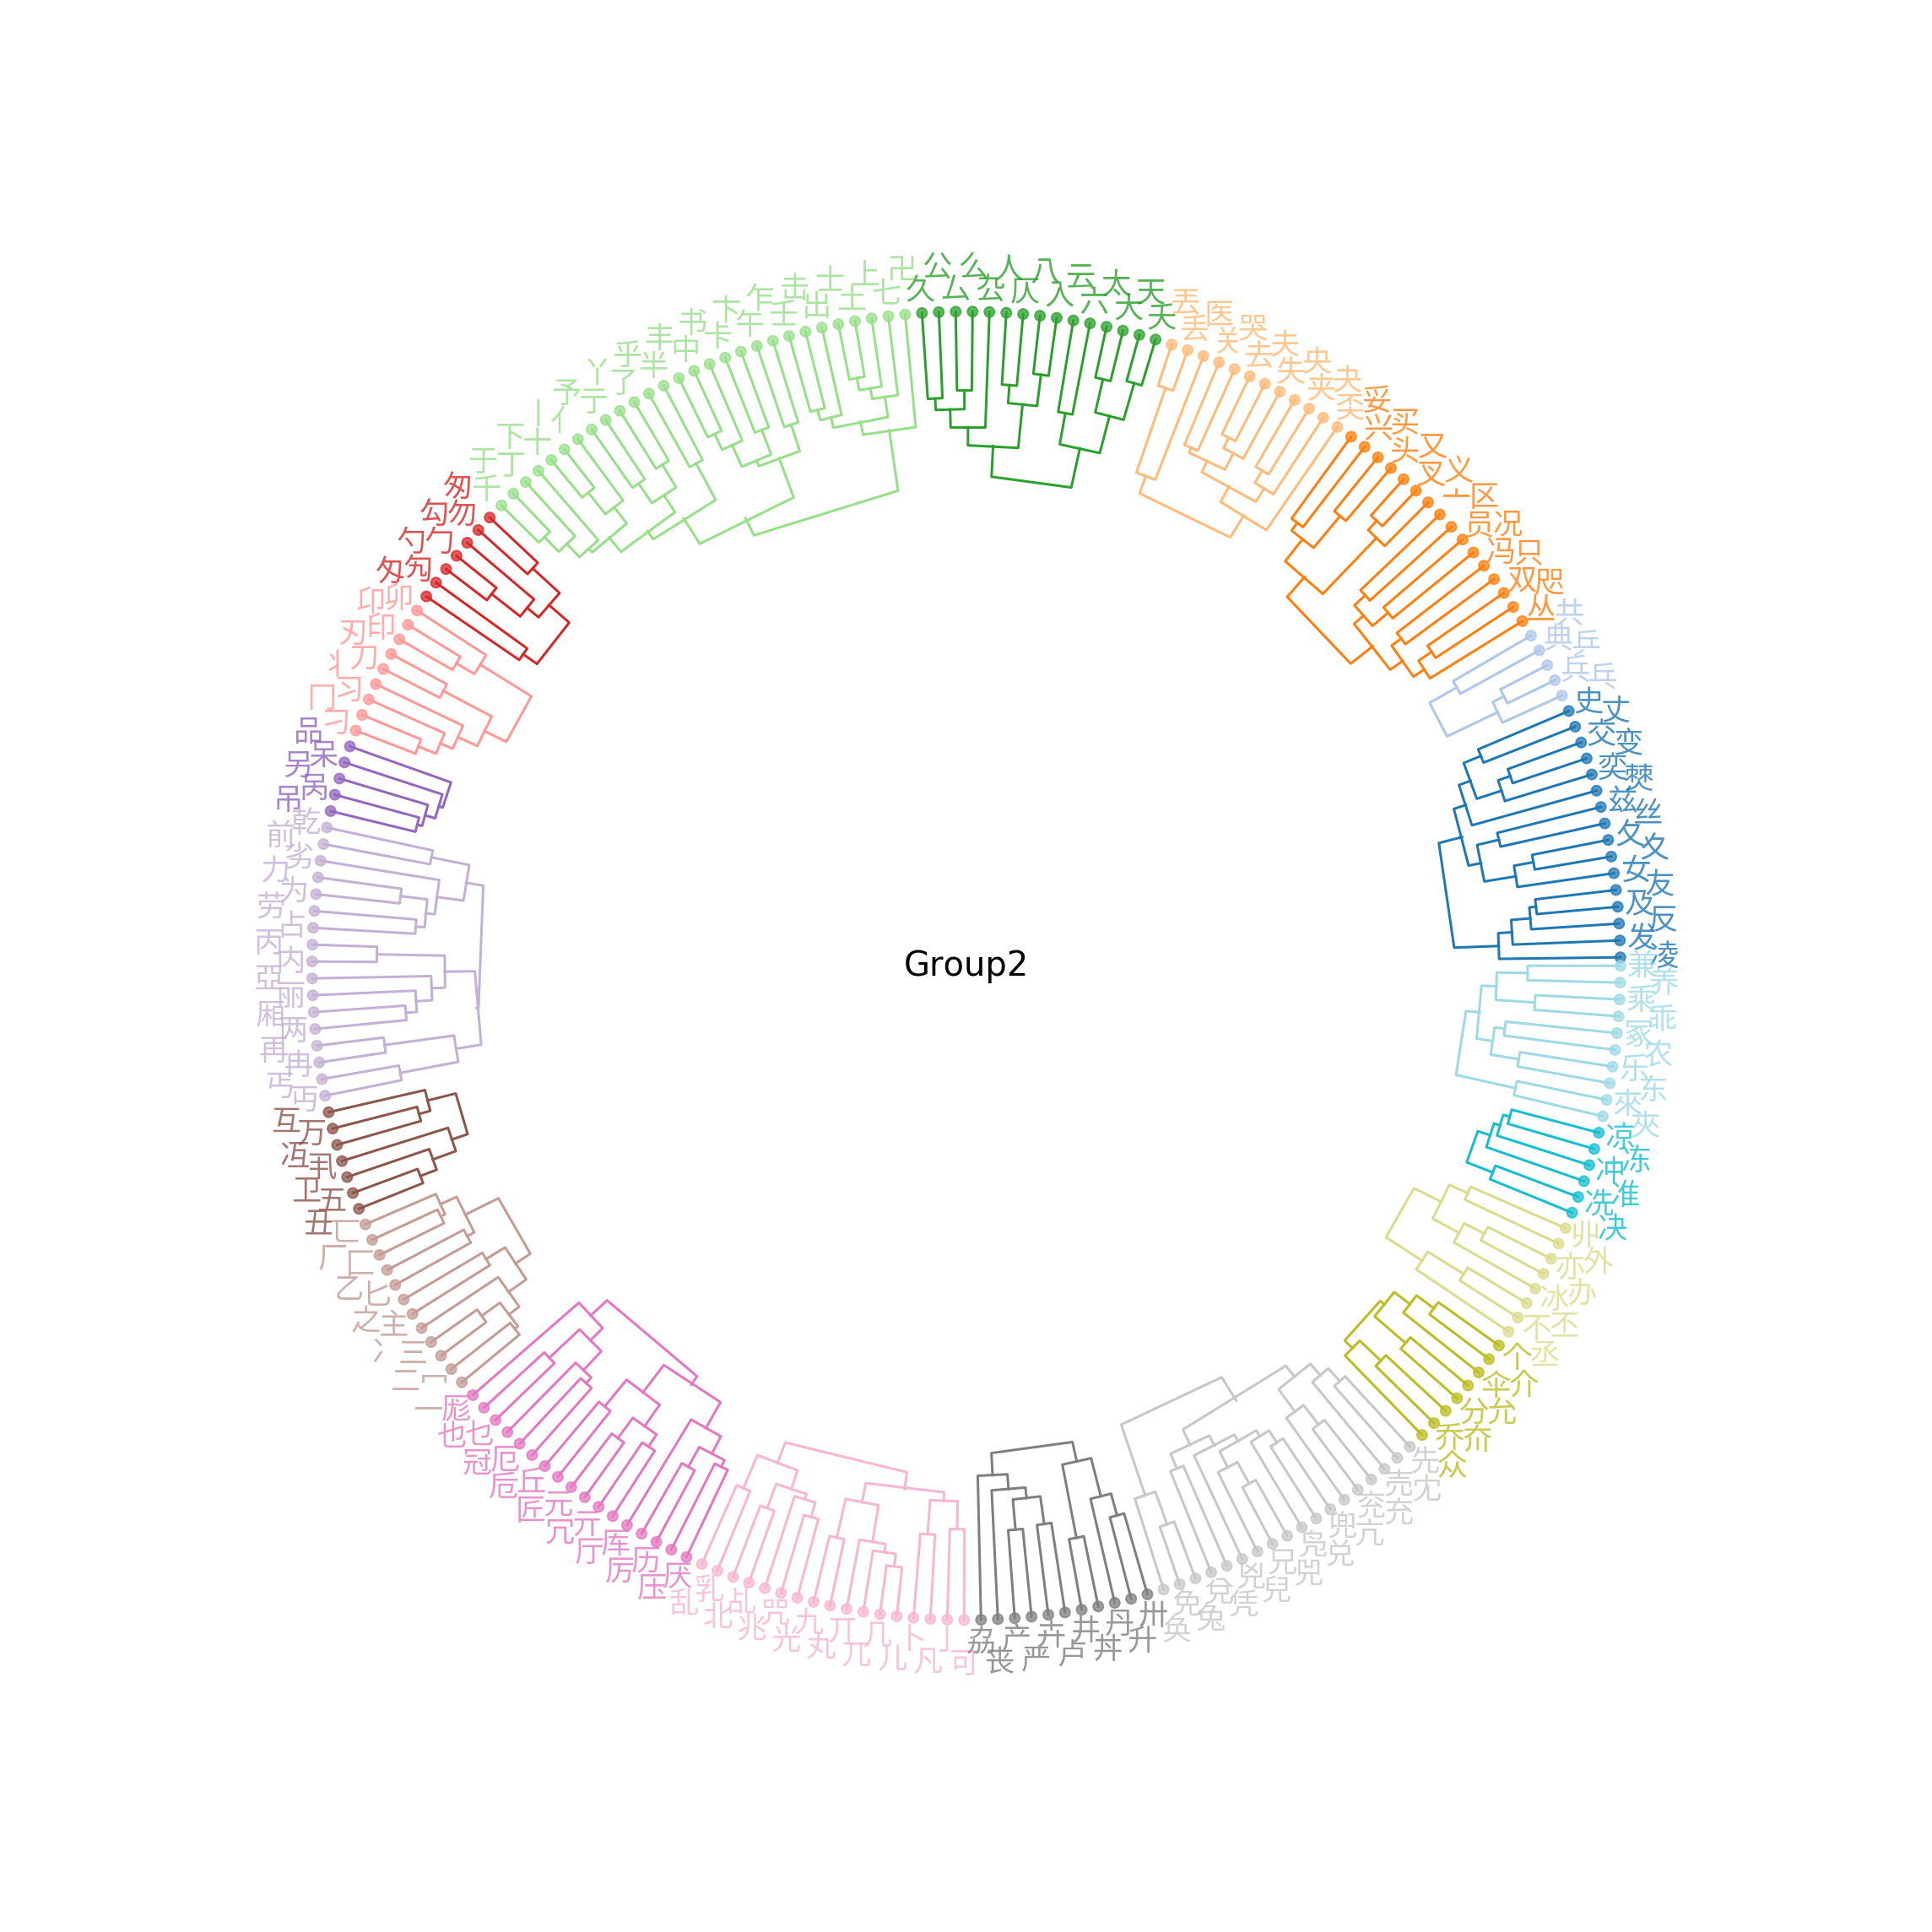

In [24]:
plot_circular_tree(dn2, L)
plt.text(0,0,"Group2",horizontalalignment='center',verticalalignment='center', fontsize = 20)
plt.tight_layout()
# plt.savefig("./commoncharacter>500_trained_result_image_24/dengrograms/group2.png")
# plt.show()

In [289]:
L1[dn2['leaves']]

array(['匯', '匜', '區', '匽', '匴', '匱', '喦', '呂', '厔', '壓', '凰', '凤', '夙',
       '厎', '匾', '叵', '厨', '圔', '圖', '圌', '圚', '圓', '圜', '園', '咼', '囿',
       '圄', '圁', '圊', '周', '圈', '司', '向', '同', '問', '囧', '冏', '卩', '刂',
       '凸', '口', '凵', '囗', '四', '凹', '回', '囪', '卤', '囱', '囟', '呴', '匈',
       '匐', '囮', '囫', '图', '圇', '囹', '囵', '圃', '團', '固', '囤', '囝', '国',
       '圉', '围', '圛', '圍', '圂', '國', '両', '兩', '凾', '函', '凼', '匟', '圆',
       '园', '囥', '內', '冈', '凶', '囷', '困', '因', '囚', '团', '囡'], dtype='<U1')